## Implementation of GANs with MNIST

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib import pyplot

import numpy as np

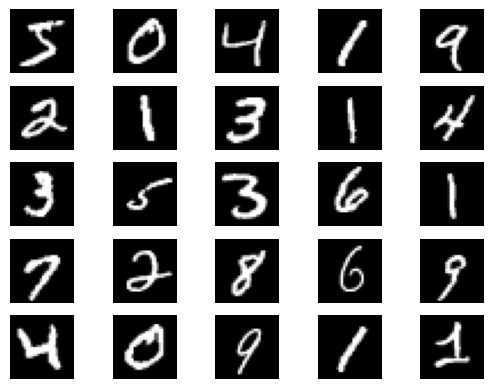

torch.Size([1, 28, 28])


In [22]:
# download dataset
# apply transformation from image to pytorch tensor
# ToTensor scales the pixel values to be 0-1
train_data = datasets.MNIST(root='./data', train=True, transform = transforms.ToTensor(), download=True)

for i in range(25):
    img_og, label = train_data[i]
    img = img_og.numpy().squeeze()
    pyplot.subplot(5, 5, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(img, cmap='gray')
pyplot.show()

print(img_og.shape)

### **Building the Discriminator**
- **Input**: Tensor with 1 channel and 28x28 height and width.
- **Output**: Likelihood 0-1 telling us if the sample is real or fake (binary classification)
- **Loss Function:** Because this is a binary classification problem, we use the binary cross entropy loss function

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=0),
            nn.Flatten(),
            nn.Linear(in_features = 2304, out_features=1)
        )
    
    def forward(self, x):
        return self.model(x)

### **Building the Generator**
- **Input**: Random point in latent space (100 element vector of Gaussian random numbers)
- **Output**: Nx1x28x28 image with pixel values [0,1]

We have to transform a vector from latent space, with 100 dimensions, into a 2D array with 28x28 values. There are a number of ways to achieve this but there is one approach that has proven to be effective at deep convolutional GANs. It involves 2 elements:
1) Dense layer with enough nodes to represent a low resolution version of the output image (7x7 pizels for example)
2) Upsampling with deconvolution

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        hidden_dim = 128 * 7 * 7 
        self.linear1 = nn.Linear(in_features=latent_dim, out_features=hidden_dim)
        self.relu = nn.ReLU()

        self.deconv1 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=4, stride=2, padding=1, output_padding=0)
        self.deconv2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=4, stride=2, padding=1, output_padding=0)

        self.conv1 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=3, padding=1)


    def forward(self, x):
        # Fully connected layer
        x = self.linear1(x)
        x = self.relu(x)
        
        # Reshape to (batch_size, 128, 7, 7)
        x = x.view(-1, 128, 7, 7)
        
        # First upsampling to (batch_size, 128, 14, 14)
        x = self.deconv1(x)

        # Second upsampling to (batch_size, 128, 28, 28)
        x = self.deconv2(x)

        # We need 1 channel outut
        x = self.conv1(x)

        return x

### **Train Model**

In [23]:
LATENT_DIM = 100
BATCH_SIZE = 64
NUM_EPOCHS = 500


generator = Generator(LATENT_DIM)
discriminator = Discriminator()

# BCEwithlogitsloss combines the sigmoid func and BCEloss
loss_func = nn.BCEWithLogitsLoss()

g_optimiser = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimiser = optim.Adam(discriminator.parameters(), lr=0.002, betas=(0.5, 0.999))

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)


In [25]:
train = False
if train:
    for epoch in range(NUM_EPOCHS):
        for i, data in enumerate(train_loader):
            real_imgs, _ = data
            real_labels = torch.ones(real_imgs.shape[0], 1)

            # # Train discriminator with real images
            d_optimiser.zero_grad()
            real_outputs = discriminator.forward(real_imgs)
            real_loss = loss_func(real_outputs, real_labels)
            real_loss.backward()

            # Train discriminator with fake images from generator
            noise = torch.randn(real_imgs.shape[0], LATENT_DIM)
            fake_imgs = generator.forward(noise)
            fake_labels = torch.zeros(real_imgs.shape[0], 1)
            fake_outputs = discriminator(fake_imgs.detach())
            fake_loss = loss_func(fake_outputs, fake_labels)
            fake_loss.backward()

            # Optimise discriminator
            d_optimiser.step()

            # Train generator
            g_optimiser.zero_grad()
            fake_labels = torch.ones(real_imgs.shape[0], 1)     # we want to trick the discriminator into thinking this is real
            fake_outputs = discriminator(fake_imgs)
            gen_loss = loss_func(fake_outputs, fake_labels)
            gen_loss.backward()

            # Optimise generator
            g_optimiser.step()

        # Print losses
        if i % 1 == 0:
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{len(train_loader)}], '
                    f'Discriminator Loss: {real_loss.item() + fake_loss.item():.4f}, '
                    f'Generator Loss: {gen_loss.item():.4f}')


The generator and discriminator learning curves will be adverserial. Typically, the discriminator's loss decreases initially, while the generator's loss increases as it struggles to produce convincing fakes. Eventually, the generator loss decreases as it learns to fool the discriminator. Ideally, the generator and discriminator reach a point of balance.